### Register and preprocess the final healthy ADC dataset
HCP-YA\
Dallas Lifespan Brain Study\
AINI-Stroke AIT

In [1]:
import os
import shutil
import tempfile
import time
import glob

import ants

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first, set_determinism
from monai.data.utils import pad_list_data_collate
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import random

import pandas as pd

import nibabel as nib

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler

from monai.metrics import compute_iou
import SimpleITK as sitk
#print_config()

from skimage.transform import resize

/bettik/PROJECTS/pr-gin5_aini/fehrdelt/environments/ddpm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#ROOT_DIR = "/home/fehrdelt/bettik/"
ROOT_DIR = "/bettik/PROJECTS/pr-gin5_aini/fehrdelt/"

(197, 233, 189)


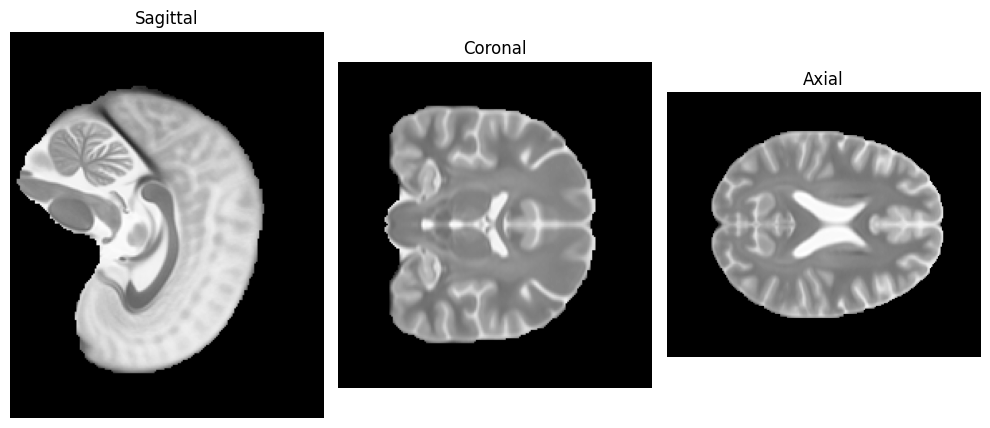

In [18]:
template_path = ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/mni_icbm152_t2_tal_nlin_sym_09a_extracted_brain.nii.gz"
template_img = nib.load(template_path)
template_data = template_img.get_fdata()
print(template_data.shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Axial slice
axes[0].imshow(template_data[template_data.shape[0] // 2, :, :], cmap="gray")
axes[0].set_title("Sagittal")
axes[0].axis("off")

# Sagittal slice
axes[1].imshow(template_data[:, template_data.shape[1] // 2, :], cmap="gray")
axes[1].set_title("Coronal")
axes[1].axis("off")

# Coronal slice
axes[2].imshow(template_data[:, :, template_data.shape[2] // 2], cmap="gray")
axes[2].set_title("Axial")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Pad and resize the template to (225,225,225)

In [23]:
original_shape = template_data.shape

# Calculate padding for each dimension
pad_width = []
for orig, target in zip(original_shape, (233, 233, 233)):
    total_pad = max(target - orig, 0)
    before = total_pad // 2
    after = total_pad - before
    pad_width.append((before, after))

# Pad the image
template_data = np.pad(template_data, pad_width, mode='constant', constant_values=0)

# Resize to (225, 225, 225)
template_data = resize(template_data, (225, 225, 225), anti_aliasing=True)

# Save the padded and resized image
padded_template_img = nib.Nifti1Image(template_data, template_img.affine, template_img.header)
output_template_path = ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/FINAL_mni_icbm152_t2_tal_nlin_sym_09a_extracted_brain_padded_resized.nii.gz"
nib.save(padded_template_img, output_template_path)

Final template
(225, 225, 225)


(-0.5, 224.5, 224.5, -0.5)

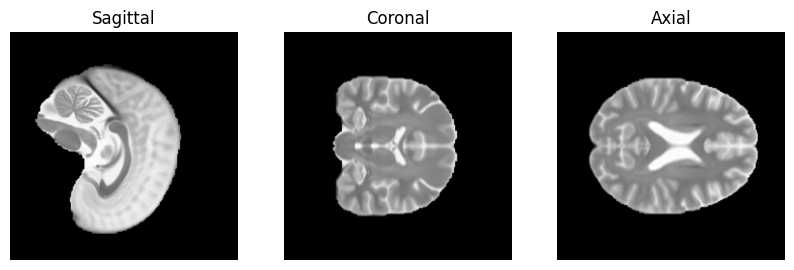

In [27]:
template_final = nib.load(output_template_path)
template_final_data = template_final.get_fdata()
print("Final template")
print(template_final_data.shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Axial slice
axes[0].imshow(template_final_data[template_final_data.shape[0] // 2, :, :], cmap="gray")
axes[0].set_title("Sagittal")
axes[0].axis("off")

# Sagittal slice
axes[1].imshow(template_final_data[:, template_final_data.shape[1] // 2, :], cmap="gray")
axes[1].set_title("Coronal")
axes[1].axis("off")

# Coronal slice
axes[2].imshow(template_final_data[:, :, template_final_data.shape[2] // 2], cmap="gray")
axes[2].set_title("Axial")
axes[2].axis("off")


## HCP-YA: 
Original Size: (174, 145, 145)\
1. pad it to (174,174,174)
2. Orient it like MNI
3. Resize it to (225, 225, 225)
4. Register it to histogram matched MNI

In [3]:
HCP_YA_folder = ROOT_DIR+"datasets/ADC_Human_Connectome_Project_Young_Adult_HCP-YA/"
HCP_YA_output_folder = ROOT_DIR+"datasets/Final_ADC_Dataset/HCP-YA/"
HCP_YA_output_folder_registered = ROOT_DIR+"datasets/Final_ADC_Dataset/HCP-YA_registered/"

#### Visualize unprocessed HCP-YA images

Image 1 shape: (174, 145, 145)
Image 2 shape: (174, 145, 145)
Image 3 shape: (174, 145, 145)
Image 4 shape: (174, 145, 145)


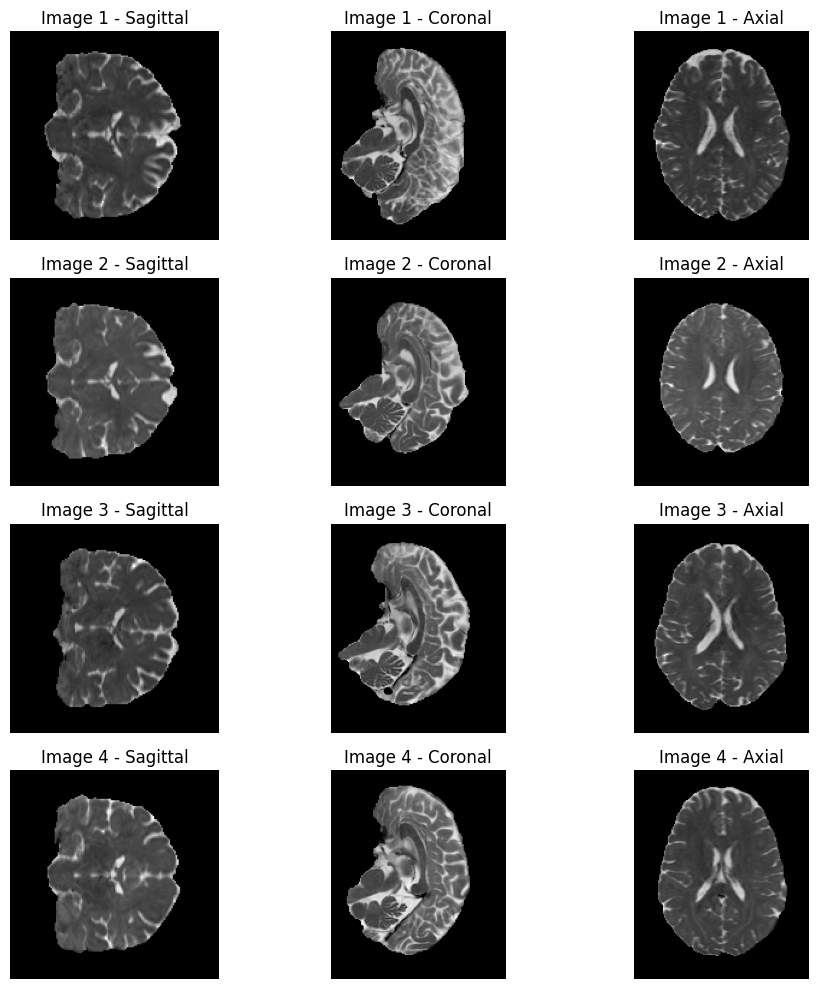

In [ ]:
# Get the first 4 image paths from the folder
image_paths = sorted(glob.glob(os.path.join(HCP_YA_folder, "*.nii.gz")))[:4]

# Plot the images
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    image = nib.load(image_path).get_fdata()
    
    print(f"Image {i+1} shape: {image.shape}")
    # Extract slices
    axial_slice = image[image.shape[0] // 2, :, :]  # Middle axial slice
    sagittal_slice = image[:, image.shape[1] // 2, :]  # Middle sagittal slice
    coronal_slice = image[:, :, image.shape[2] // 2]  # Middle coronal slice

    # Plot slices
    axes[i, 0].imshow(axial_slice, cmap="gray")
    axes[i, 0].set_title(f"Image {i+1} - Sagittal")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sagittal_slice, cmap="gray")
    axes[i, 1].set_title(f"Image {i+1} - Coronal")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(coronal_slice, cmap="gray")
    axes[i, 2].set_title(f"Image {i+1} - Axial")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

#### Procees HCP-YA images

In [32]:
def histogram_match_nifti(input_image_path, reference_image_path, output_image_path):
    """
    Performs histogram matching on a 3D NIfTI image based on a reference image.

    Parameters:
    - input_image_path: Path to the input NIfTI image to be matched.
    - reference_image_path: Path to the reference NIfTI image.
    - output_image_path: Path to save the histogram-matched NIfTI image.
    """
    # Load the input and reference images using SimpleITK
    input_image = sitk.ReadImage(input_image_path, sitk.sitkFloat32)
    reference_image = sitk.ReadImage(reference_image_path, sitk.sitkFloat32)

    # Perform histogram matching
    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(256)
    matcher.SetNumberOfMatchPoints(15)
    matcher.SetThresholdAtMeanIntensity(True)

    matched_image = matcher.Execute(input_image, reference_image)

    # Save the matched image
    sitk.WriteImage(matched_image, output_image_path)

# histogram matching the template to the first hcp-ya image
histogram_match_nifti(input_image_path=output_template_path, 
                      reference_image_path=HCP_YA_folder+"104416.nii.gz", 
                      output_image_path=ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/hist_match_to_hcp_ya_FINAL_mni_icbm152_t2.nii.gz")

Final template
(225, 225, 225)


(-0.5, 224.5, 224.5, -0.5)

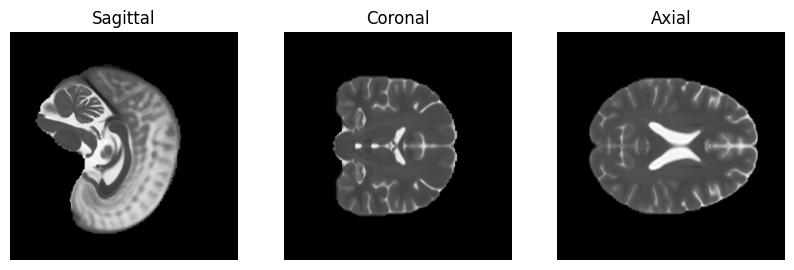

In [33]:
hist_match_template_final = nib.load(ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/hist_match_to_hcp_ya_FINAL_mni_icbm152_t2.nii.gz")
hist_match_template_final_data = hist_match_template_final.get_fdata()
print("Final template")
print(hist_match_template_final_data.shape)
fig, axes = plt.subplots(1, 3, figsize=(10, 10))

# Axial slice
axes[0].imshow(hist_match_template_final_data[hist_match_template_final_data.shape[0] // 2, :, :], cmap="gray")
axes[0].set_title("Sagittal")
axes[0].axis("off")

# Sagittal slice
axes[1].imshow(hist_match_template_final_data[:, hist_match_template_final_data.shape[1] // 2, :], cmap="gray")
axes[1].set_title("Coronal")
axes[1].axis("off")

# Coronal slice
axes[2].imshow(hist_match_template_final_data[:, :, hist_match_template_final_data.shape[2] // 2], cmap="gray")
axes[2].set_title("Axial")
axes[2].axis("off")


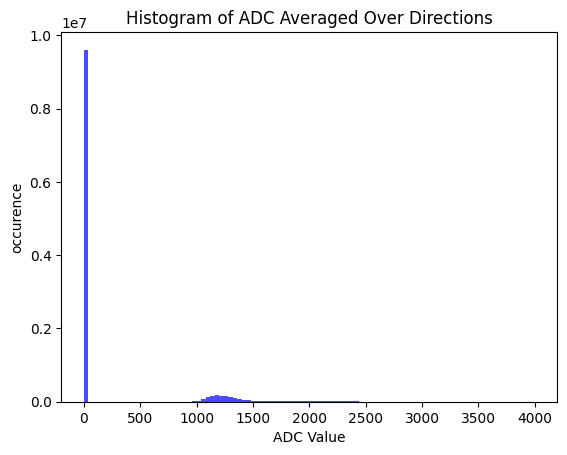

In [34]:
plt.hist(hist_match_template_final_data.flatten(), bins=100, color='blue', alpha=0.7)
plt.title('Histogram of ADC Averaged Over Directions')
plt.xlabel('ADC Value')
plt.ylabel('occurence')
plt.show()

In [5]:
# Create output folder for padded images
os.makedirs(HCP_YA_output_folder, exist_ok=True)

nifti_files = sorted(glob.glob(os.path.join(HCP_YA_folder, "*.nii.gz")))

for file_path in tqdm(nifti_files):
    out_path = os.path.join(HCP_YA_output_folder, os.path.basename(file_path))
    if not os.path.exists(out_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        
        original_shape = data.shape

        # Calculate padding for each dimension
        pad_width = []
        for orig, target in zip(original_shape, (174, 174, 174)):
            total_pad = max(target - orig, 0)
            before = total_pad // 2
            after = total_pad - before
            pad_width.append((before, after))

        # Pad the image
        data = np.pad(data, pad_width, mode='constant', constant_values=0)

        # Rotate it 90 degrees
        data  = np.rot90(data, 3, axes=(0, 1)) 

        # Resize to (225, 225, 225)
        data = resize(data, (225, 225, 225), anti_aliasing=True)

        
        # Save padded image
        padded_img = nib.Nifti1Image(data, img.affine, img.header)
        
        nib.save(padded_img, out_path)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1015/1015 [18:12<00:00,  1.08s/it]


Image 1 shape: (225, 225, 225)
Image 2 shape: (225, 225, 225)
Image 3 shape: (225, 225, 225)
Image 4 shape: (225, 225, 225)


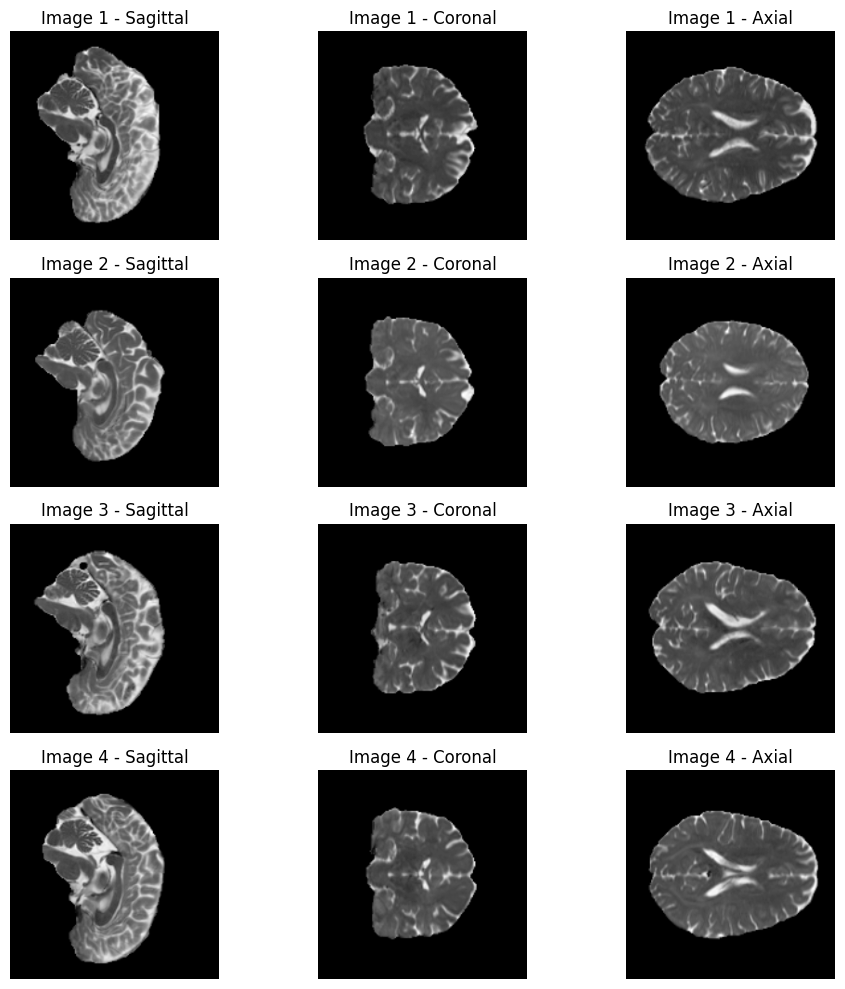

In [6]:
# Get the first 4 image paths from the folder
image_paths = sorted(glob.glob(os.path.join(HCP_YA_output_folder, "*.nii.gz")))[:4]

# Plot the images
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    image = nib.load(image_path).get_fdata()
    
    print(f"Image {i+1} shape: {image.shape}")
    # Extract slices
    axial_slice = image[image.shape[0] // 2, :, :]  # Middle axial slice
    sagittal_slice = image[:, image.shape[1] // 2, :]  # Middle sagittal slice
    coronal_slice = image[:, :, image.shape[2] // 2]  # Middle coronal slice

    # Plot slices
    axes[i, 0].imshow(axial_slice, cmap="gray")
    axes[i, 0].set_title(f"Image {i+1} - Sagittal")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sagittal_slice, cmap="gray")
    axes[i, 1].set_title(f"Image {i+1} - Coronal")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(coronal_slice, cmap="gray")
    axes[i, 2].set_title(f"Image {i+1} - Axial")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [4]:


def register_nifti_files(fixed_reference, dataset_path, output_path, register_masks=False, dataset_masks_path=None, output_mask_path=None):
    """
    Registers all NIfTI files in the dataset_path folder to the same space using ANTs.

    Parameters:
    - dataset_path: Path to the folder containing NIfTI files.
    - output_path: Path to save the registered NIfTI files.
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Get all NIfTI files in the dataset_path
    nifti_files = sorted(glob.glob(os.path.join(dataset_path, "*.nii*")))
    if register_masks:nifti_masks_files = sorted(glob.glob(os.path.join(dataset_masks_path, "*.nii*")))
    print("nifti_files", nifti_files)
    if register_masks: print("nifti_masks_files", nifti_masks_files)
    if not nifti_files:
        print("No NIfTI files found in the dataset path.")
        return

    # Use the first file as the fixed image (reference)
    fixed_image = ants.image_read(fixed_reference)

    for i, moving_file in enumerate(tqdm(nifti_files)):
        #print(f"file {i} of {len(nifti_files)}")
        output_filepath = os.path.join(output_path, os.path.basename(moving_file))

        if register_masks:
            mask_file = nifti_masks_files[i]
            output_mask_filepath = os.path.join(output_mask_path, os.path.basename(mask_file))
        
        
        if not os.path.isfile(output_filepath):
            moving_image = ants.image_read(moving_file)
            
            # Perform registration
            registration = ants.registration(fixed=fixed_image, moving=moving_image, type_of_transform='Similarity') # https://antspy.readthedocs.io/en/latest/registration.html types of transforms

            # for the mask
            if register_masks:
                mask_image = ants.image_read(mask_file)
                transform = registration['fwdtransforms']
                mask_moved = ants.apply_transforms(fixed_image, mask_image, transformlist=transform, interpolation='nearestNeighbor')
                mask_moved.to_file(output_mask_filepath)

            # Save the registered image
            ants.image_write(registration['warpedmovout'], output_filepath)
    
            #print(f"Registered {moving_file} and saved to {output_filepath}")
        else:
            pass
            #print("skipped registration already done")



register_nifti_files(fixed_reference=ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/hist_match_to_hcp_ya_FINAL_mni_icbm152_t2.nii.gz", 
                     dataset_path=HCP_YA_output_folder, 
                     output_path=HCP_YA_output_folder_registered)

nifti_files ['/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/100206.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/100307.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/100408.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/100610.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/101006.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/101107.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/101309.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/101410.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/101915.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/102008.nii.gz', '/bettik/PROJECTS/pr-gin5_aini/fehrdelt/datasets/Final_ADC_Dataset/HCP-YA/102109.nii.gz

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 898/1015 [2:02:55<16:00,  8.21s/it]


KeyboardInterrupt: 

## Dallas Lifespan Brain Study
Original Size: (224, 224, 150)\
1. Resample it to 1mm3
1. pad it to (225, 225, 225)
2. Orient it like MNI
4. Register it to histogram matched MNI

In [ ]:
dallas_adc_unprocessed_folder = ROOT_DIR+"/datasets/Dallas_Computed_ADC_extracted_brain/"
dallas_resampled_output_folder = ROOT_DIR+"/datasets/Dallas_Computed_ADC_extracted_brain_resampled/"

dallas_final_output_folder = ROOT_DIR+"datasets/Final_ADC_Dataset/Dallas/"
dallas_final_output_folder_registered = ROOT_DIR+"datasets/Final_ADC_Dataset/Dallas_registered/"

In [ ]:
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0]):
    # Resample images to 2mspecified spacing with SimpleITK

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())


    resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

In [ ]:
for image_path in tqdm(glob.glob(os.path.join(dallas_adc_unprocessed_folder, "*.nii.gz"))):
    itk_image = sitk.ReadImage(image_path)
    resampled_image = resample_img(itk_image)
    output_path = os.path.join(dallas_resampled_output_folder, os.path.basename(image_path))
    sitk.WriteImage(resampled_image, output_path)


Image 1 shape: (224, 224, 150)
Image 2 shape: (224, 224, 150)
Image 3 shape: (224, 224, 150)
Image 4 shape: (224, 224, 150)


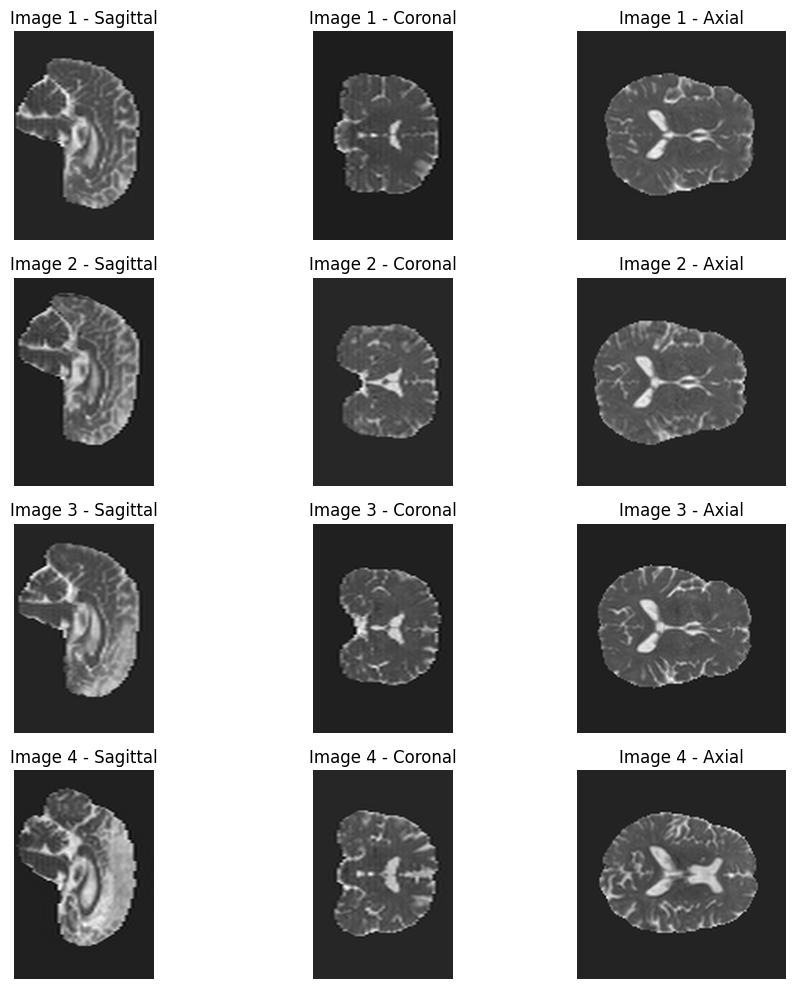

In [ ]:
# Get the first 4 image paths from the folder
image_paths = sorted(glob.glob(os.path.join(dallas_resampled_output_folder, "*.nii.gz")))[:4]

# Plot the images
plt.suptitle("Dallas Resampled Images 1mm3")
fig, axes = plt.subplots(4, 3, figsize=(10, 10))
for i, image_path in enumerate(image_paths):
    image = nib.load(image_path).get_fdata()
    print(f"Image {i+1} shape: {image.shape}")
    # Extract slices
    axial_slice = image[image.shape[0] // 2, :, :]  # Middle axial slice
    sagittal_slice = image[:, image.shape[1] // 2, :]  # Middle sagittal slice
    coronal_slice = image[:, :, image.shape[2] // 2]  # Middle coronal slice

    # Plot slices
    axes[i, 0].imshow(axial_slice, cmap="gray")
    axes[i, 0].set_title(f"Image {i+1} - Sagittal")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(sagittal_slice, cmap="gray")
    axes[i, 1].set_title(f"Image {i+1} - Coronal")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(coronal_slice, cmap="gray")
    axes[i, 2].set_title(f"Image {i+1} - Axial")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Create output folder for padded images
os.makedirs(dallas_resampled_output_folder, exist_ok=True)

nifti_files = sorted(glob.glob(os.path.join(dallas_resampled_output_folder, "*.nii.gz")))

for file_path in tqdm(nifti_files):
    out_path = os.path.join(dallas_final_output_folder, os.path.basename(file_path))
    if not os.path.exists(out_path):
        img = nib.load(file_path)
        data = img.get_fdata()
        
        original_shape = data.shape

        # Calculate padding for each dimension
        pad_width = []
        for orig, target in zip(original_shape, (225, 225, 225)):
            total_pad = max(target - orig, 0)
            before = total_pad // 2
            after = total_pad - before
            pad_width.append((before, after))

        # Pad the image
        data = np.pad(data, pad_width, mode='constant', constant_values=0)

        
        # Save padded image
        padded_img = nib.Nifti1Image(data, img.affine, img.header)
        
        nib.save(padded_img, out_path)

In [ ]:

register_nifti_files(fixed_reference=ROOT_DIR+"datasets/mni_icbm152_nlin_sym_09a/hist_match_to_hcp_ya_FINAL_mni_icbm152_t2.nii.gz", 
                     dataset_path=dallas_final_output_folder, 
                     output_path=dallas_final_output_folder_registered)

## Last step: visualize all images and get rid of the bad ones